# 0. Introduction

*Author*: Pablo Fernández

## 0.1. Libraries

In [1]:
import pandas as pd
import re  # For regex expressions
import collections  # For counting
from nltk.corpus import stopwords  # Stopwords list
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from hw1_library import metrics, preprocessing, regex_classifiers

## 0.2. Data

**Dataset**: https://huggingface.co/datasets/rotten_tomatoes

### Data loading

In [2]:
splits = {'train': 'train.parquet', 'validation': 'validation.parquet', 'test': 'test.parquet'}

df_train = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["train"])

df_val = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["validation"])

df_test = pd.read_parquet("hf://datasets/cornell-movie-review-data/rotten_tomatoes/" + splits["test"])

df_dict = {
    "train": df_train,
    "validation": df_val,
    "test": df_test
}

/home/pablo/.cache/pypoetry/virtualenvs/bse-nlp-y6-47KiC-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Basic EDA

In [3]:
df_train.head()

,text,label
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


Features (taken from the dataset's website):
- `text`: a string feature.
- `label`: a classification label, with possible values including *neg* (0, which stands for negative reviews), *pos* (1, which stands for positive reviews).

In [4]:
# Print the number of rows in each split
print("Number of rows in each split:")
for split, df in df_dict.items():
    print(f"{split}: {len(df)}")

Number of rows in each split:
train: 8530
validation: 1066
test: 1066


Below, we check how balanced is the data: what is the ratio of positive and negative reviews in each split?

In [5]:
# Print the proportion of positive and negative reviews in each split
print("Proportion of positive and negative reviews in each split:")
for split, df in df_dict.items():
    pos_count = len(df[df['label'] == 1])
    neg_count = len(df[df['label'] == 0])
    total_count = len(df)
    pos_proportion = pos_count / total_count
    neg_proportion = neg_count / total_count
    print(f"{split}: Positive: {pos_proportion:.2f}, Negative: {neg_proportion:.2f}")

Proportion of positive and negative reviews in each split:
train: Positive: 0.50, Negative: 0.50
validation: Positive: 0.50, Negative: 0.50
test: Positive: 0.50, Negative: 0.50


As can be seen above, the data is highly balanced in all of the splits.

Finally, how long are, on average, the reviews in each split?

In [6]:
for split, df in df_dict.items():
    
    # Compute the total length of each review per split
    if 'text_length' not in df.columns:
        df['text_length'] = df['text'].apply(lambda x: len(x.split()))
    
    # Compute the unique word count for each review
    df['unique_word_count'] = df['text'].apply(lambda x: len(set(x.split())))
    
    print(f"\nSummary statistics for {split} split:")
    print("--" * 40)

    print(df.describe())


Summary statistics for train split:
--------------------------------------------------------------------------------
             label  text_length  unique_word_count
count  8530.000000  8530.000000        8530.000000
mean      0.500000    20.992849          18.837515
std       0.500029     9.371094           7.822833
min       0.000000     1.000000           1.000000
25%       0.000000    14.000000          13.000000
50%       0.500000    20.000000          19.000000
75%       1.000000    27.000000          24.000000
max       1.000000    59.000000          45.000000

Summary statistics for validation split:
--------------------------------------------------------------------------------
             label  text_length  unique_word_count
count  1066.000000  1066.000000        1066.000000
mean      0.500000    20.997186          18.745779
std       0.500235     9.639950           7.967075
min       0.000000     1.000000           1.000000
25%       0.000000    14.000000          13.0

We can quickly observe that, overall, the included texts (reviews) are short in length (on average, of 21 words).

## 0.3. Submission Guidelines

- Document your code, analysis, and findings in a Jupyter notebook. 1 point on code quality/presentation of results.
- Include comments and markdown cells to explain your logic and interpretations at each step.
- Submit the notebook file via colab.

# 1. Part 1: Rule-based Analysis using regexes (2 points)

**Objective**: Utilize regexes to classify movie reviews as positive or negative based on predefined linguistic rules.

To do this, first we must get a basic idea of the most common words of positive and negative reviews. A basic approach to do this is shown below, where I tokenize the reviews depending on the type of review (positive - 1 or negative - 0). 

In [7]:
# We extract the text of the positive reviews and the text of the negative reviews as numpy arrays
pos_reviews = df_train[df_train["label"] == 1]["text"].values
neg_reviews = df_train[df_train["label"] == 0]["text"].values

print(pos_reviews[0:2])

['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .'
 'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .']


Note that below we do not remove digits, as in this case they might contain relevant information about the sentiment of the review.

In [8]:
my_stop_words = set(stopwords.words('english'))

# Tokenize the positive reviews (creates a 2-D list, where each list is a review)
pos_reviews_tokens = [preprocessing.tokenize(review, rm_stopwords=True, stopword_set=my_stop_words) for review in pos_reviews]
# Tokenize the negative reviews (creates a 2-D list, where each list is a review)
neg_reviews_tokens = [preprocessing.tokenize(review, rm_stopwords=True, stopword_set=my_stop_words) for review in neg_reviews]

print("Tokenized positive reviews:")
print(pos_reviews_tokens[0:2])
print("\nTokenized negative reviews:")
print(neg_reviews_tokens[0:2])

Tokenized positive reviews:
[['rock', 'destined', '21st', 'century', 'new', 'conan', 'going', 'make', 'splash', 'even', 'greater', 'arnold', 'schwarzenegger', 'jean', 'claud', 'van', 'damme', 'steven', 'segal'], ['gorgeously', 'elaborate', 'continuation', 'lord', 'rings', 'trilogy', 'huge', 'column', 'words', 'cannot', 'adequately', 'describe', 'co', 'writer', 'director', 'peter', 'jackson', 'expanded', 'vision', 'j', 'r', 'r', 'tolkien', 'middle', 'earth']]

Tokenized negative reviews:
[['simplistic', 'silly', 'tedious'], ['laddish', 'juvenile', 'teenage', 'boys', 'could', 'possibly', 'find', 'funny']]


In [9]:
# Flatten the lists of tokens
pos_reviews_flat = [token for review in pos_reviews_tokens for token in review]
neg_reviews_flat = [token for review in neg_reviews_tokens for token in review]

# Count the frequency of each token in the positive reviews
pos_counter = collections.Counter(pos_reviews_flat)
neg_counter = collections.Counter(neg_reviews_flat)

In [10]:
print("Positive review token counts (10 most common words):")
print(pos_counter.most_common(10))

print("\nNegative review token counts (10 most common words):")
print(neg_counter.most_common(10))

Positive review token counts (10 most common words):
[('film', 695), ('movie', 445), ('one', 288), ('like', 223), ('story', 197), ('good', 177), ('comedy', 167), ('well', 150), ('even', 146), ('funny', 144)]

Negative review token counts (10 most common words):
[('movie', 671), ('film', 563), ('like', 364), ('one', 310), ('story', 190), ('much', 179), ('bad', 176), ('time', 161), ('even', 161), ('good', 152)]


Note that, as seen above (section 0.2), negative reviews are, on average, of the same length of positive reviews (in the training, validation and test splits). Therefore, even if this rule-based analysis is a naive approach, it is reasonable to compare the most frequent words for each type of reviews.  

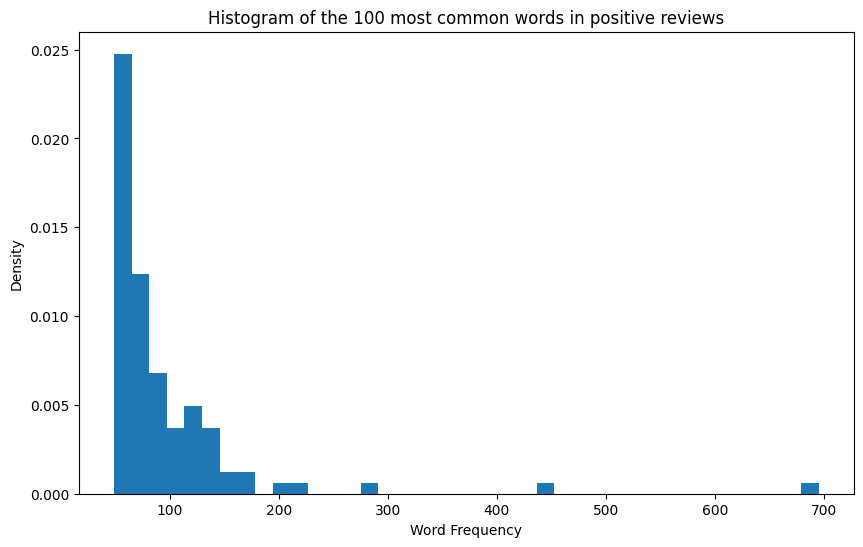

In [11]:
num_most_common = 100

# We get the frequency of the most common words in the positive reviews
pos_counter_most_common = pos_counter.most_common(num_most_common)

# Extract the words and frequency of the words of positive reviews
pos_common_words, pos_common_freq = zip(*pos_counter_most_common)

# Kernel density estimation
plt.figure(figsize=(10, 6))
plt.hist(pos_common_freq, bins=40, density=True)
plt.title(f"Histogram of the {num_most_common} most common words in positive reviews")
plt.xlabel("Word Frequency")
plt.ylabel("Density")
plt.show()

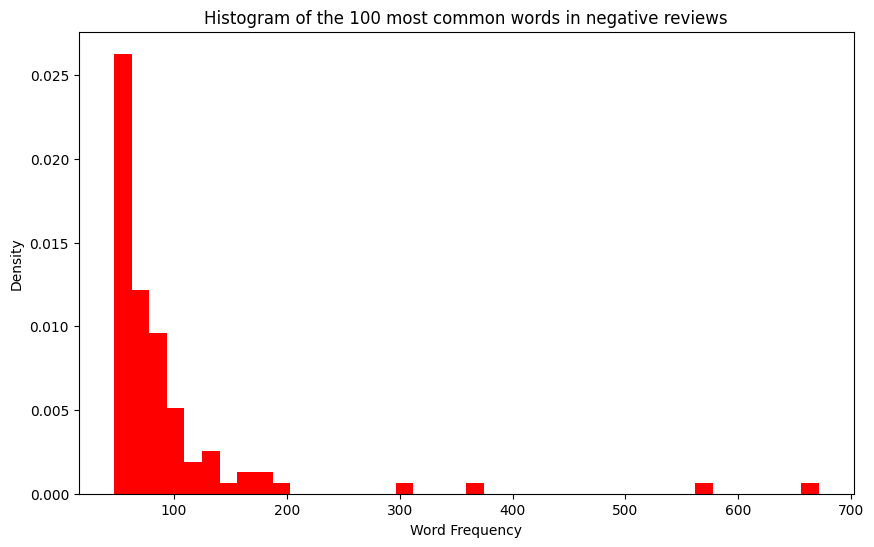

In [12]:
# We get the frequency of the most common words in the negative reviews
neg_counter_most_common = neg_counter.most_common(num_most_common)

# Extract the words and frequency of the words of negative reviews
neg_common_words, neg_common_freq = zip(*neg_counter_most_common)

# Kernel density estimation
plt.figure(figsize=(10, 6))
plt.hist(neg_common_freq, bins=40, density=True, color='red')
plt.title(f"Histogram of the {num_most_common} most common words in negative reviews")
plt.xlabel("Word Frequency")
plt.ylabel("Density")
plt.show()

As expected, there is a large difference between the words with the highest frequency and the common words but with lower frequency. However, we can observe a clear problem in the simple inspection of the word counts above: the most common words are the same for both type of reviews! To solve that, we can simply consider the words that are NOT in the other type of reviews, which will further refine the stopword removal and help us differentiate the reviews.

In [13]:
# Create set of common words for both positive and negative reviews
pos_common_words_set = set(pos_common_words)
neg_common_words_set = set(neg_common_words)

# Get the intersection of the two sets
common_words_set = pos_common_words_set.intersection(neg_common_words_set)

# Remove the intersection from the positive and negative common words
pos_common_words_set = pos_common_words_set - common_words_set
neg_common_words_set = neg_common_words_set - common_words_set

print("\nPositive common words (without intersection):")
print(pos_common_words_set)
print(f"Number of positive common words (without intersection): {len(pos_common_words_set)}")
print("\nNegative common words (without intersection):")
print(neg_common_words_set)
print(f"Number of negative common words (without intersection): {len(neg_common_words_set)}")


Positive common words (without intersection):
{'performance', 'take', 'ever', 'entertaining', 'american', 'performances', 'cinema', 'compelling', 'family', 'moving', 'cast', 'world', 'fun', 'music', 'often', 'works', 'documentary', 'heart', 'man', 'fascinating', 'still', 'tale', 'gives', 'human', 'seen', 'worth', 'yet', 'de', 'romantic', 'part', 'right', 'great'}
Number of positive common words (without intersection): 32

Negative common words (without intersection):
{'acting', 'despite', 'nothing', 'comes', 'almost', 'silly', 'rather', 'point', 'thing', 'seem', 'hard', 'things', 'video', 'dialogue', 'lot', 'half', 'go', 'minutes', 'seems', 'feels', 'script', 'end', 'dull', 'interesting', 'another', 'watching', 'quite', 'less', 'material', 'ultimately', 'tv', 'bad'}
Number of negative common words (without intersection): 32


## 1.1. Positive Reviews Rule Creation

(0.5 points): Develop a rule using regexes to identify phrases commonly found in positive reviews. Justify your choice of patterns.

Below, we use a simple rule where, if one of the words of the set of positive reviews created above appears in a review, it will be classified as a positive review, otherwise it will be classified as a negative review.

In [14]:
# We create a regex pattern to match the common words of positive reviews:
# it captures ANY of the words in the set created above and ignores the case
pattern = re.compile(r"(" + "|".join(pos_common_words_set) + r")", re.IGNORECASE)

# Extract the true labels of the validation set
y_val_true = df_val["label"].to_list()

# For each review, make the predictions using the regex classifier
y_val_pred_pos_match = [regex_classifiers.regex_classifier(review, pattern, match_label=1) for review in df_val["text"].values]

print(y_val_true[0:5])
print(y_val_pred_pos_match[0:5])

[1, 1, 1, 1, 1]
[0, 1, 1, 1, 1]


In [15]:
# Inspect the text of the first 5 predictions of the validation set
for i in range(5):
    print(f"Review: {df_val['text'].values[i]}")
    print(f"True label: {y_val_true[i]}, Predicted label: {y_val_pred_pos_match[i]}")
    print("-" * 80)

Review: compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .
True label: 1, Predicted label: 0
--------------------------------------------------------------------------------
Review: the soundtrack alone is worth the price of admission .
True label: 1, Predicted label: 1
--------------------------------------------------------------------------------
Review: rodriguez does a splendid job of racial profiling hollywood style--casting excellent latin actors of all ages--a trend long overdue .
True label: 1, Predicted label: 1
--------------------------------------------------------------------------------
Review: beneath the film's obvious determination to shock at any cost lies considerable skill and determination , backed by sheer nerve .
True label: 1, Predicted label: 1
--------------------------------------------------------------------------------
Review: bielinsky is a filmmaker of imp

Prediction errors:
- In the first review, the pattern is finding `seem` in `seemingly`, which is included as part of the set of words of negative reviews. This triggers a false negative.
- In the third review, it is apparently matching `end` (in the set of words of negative reviews) with `trend`, which creates a false negative.

In [16]:
metrics_val = metrics.Metrics()

metrics_val.run(
    y_true=y_val_true,
    y_pred=y_val_pred_pos_match,
    method_name="Regex Classifier (Positive Match)",
    average='macro'
)

metrics_val.print_results()

Metrics calculated for: Regex Classifier (Positive Match)

Metrics for Regex Classifier (Positive Match)

Accuracy: 55.82%

Precision: 56.38%

Recall: 55.82%

F1 Score: 54.81%


This baseline classifier that detects positive reviews:
- Creates several false positives, which leads to an accuracy and precision which are only slightly better than random guessing.
- Is not very good at detecting positive instances, which leads to a relatively low recall (true positive predictions over all positive instances). 

## 1.2. Negative Reviews Rule Creation 

(0.5 points): Create a similar rule for detecting negative reviews. Explain the rationale behind the patterns selected.

In [17]:
# We create a regex pattern to match the common words of negative reviews:
# it captures ANY of the words in the set created above and ignores the case
pattern = re.compile(r"(" + "|".join(neg_common_words_set) + r")", re.IGNORECASE)

# Extract the true labels of the validation set
y_val_true = df_val["label"].values

# For each review, make the predictions using the regex classifier
y_val_pred_neg_match = [regex_classifiers.regex_classifier(review, pattern, match_label=0) for review in df_val["text"].values]

print(y_val_true[0:5])
print(y_val_pred_neg_match[0:5])

[1 1 1 1 1]
[0, 1, 0, 1, 1]


In [18]:
# Inspect the text of the first 5 predictions of the validation set
for i in range(5):
    print(f"Review: {df_val['text'].values[i]}")
    print(f"True label: {y_val_true[i]}, Predicted label: {y_val_pred_neg_match[i]}")
    print("-" * 80)

Review: compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .
True label: 1, Predicted label: 0
--------------------------------------------------------------------------------
Review: the soundtrack alone is worth the price of admission .
True label: 1, Predicted label: 1
--------------------------------------------------------------------------------
Review: rodriguez does a splendid job of racial profiling hollywood style--casting excellent latin actors of all ages--a trend long overdue .
True label: 1, Predicted label: 0
--------------------------------------------------------------------------------
Review: beneath the film's obvious determination to shock at any cost lies considerable skill and determination , backed by sheer nerve .
True label: 1, Predicted label: 1
--------------------------------------------------------------------------------
Review: bielinsky is a filmmaker of imp

In [19]:
metrics_val.run(
    y_true=y_val_true,
    y_pred=y_val_pred_neg_match,
    method_name="Regex Classifier (Negative Match)",
    average='macro'
)

metrics_val.print_results()

Metrics calculated for: Regex Classifier (Negative Match)

Metrics for Regex Classifier (Positive Match)

Accuracy: 55.82%

Precision: 56.38%

Recall: 55.82%

F1 Score: 54.81%

Metrics for Regex Classifier (Negative Match)

Accuracy: 57.41%

Precision: 57.47%

Recall: 57.41%

F1 Score: 57.33%


Compared to the positive reviews detection, this rule-based system of detecting negative reviews is performing relatively better, over all metrics. This might denote that the **most common words of negative reviews used is more different than the most common words of positive reviews**. 

## 1.3. Reducing False Positives 

(1 point): Propose and implement a rule to minimize false positives in your classifications. Discuss the improvements observed.

In [20]:
y_val_true = df_val["label"].to_list()

# Let's identify the false positives and negatives for positive match
fp_indices_pos_match = []  # Predicted positive but actually negative
fn_indices_pos_match = []  # Predicted negative but actually positive

print("False Positives and Negatives for Regex Baseline (Positive Match):")
print("-----------------------------------------------------")

for i, (true, pred) in enumerate(zip(y_val_true, y_val_pred_pos_match)):
    if true == 0 and pred == 1:
        fp_indices_pos_match.append(i)
    elif true == 1 and pred == 0:
        fn_indices_pos_match.append(i)

print("False Positives:", len(fp_indices_pos_match), "examples")
print("False Negatives:", len(fn_indices_pos_match), "examples")

# Print the first 5 false positives
print("\nFalse Positives (Regex Baseline - Positive Match):")
for i in fp_indices_pos_match[:5]:
    print(f"Review: {df_val['text'].values[i]}")
    print(f"True label: {y_val_true[i]}, Predicted label: {y_val_pred_pos_match[i]}")
    print("-" * 80)

# Print the first 5 false negatives
print("\nFalse Negatives (Regex Baseline - Positive Match):")
for i in fn_indices_pos_match[:5]:
    print(f"Review: {df_val['text'].values[i]}")
    print(f"True label: {y_val_true[i]}, Predicted label: {y_val_pred_pos_match[i]}")
    print("-" * 80)

False Positives and Negatives for Regex Baseline (Positive Match):
-----------------------------------------------------
False Positives: 315 examples
False Negatives: 156 examples

False Positives (Regex Baseline - Positive Match):
Review: bogs down badly as we absorb jia's moody , bad-boy behavior which he portrays himself in a one-note performance .
True label: 0, Predicted label: 1
--------------------------------------------------------------------------------
Review: the camera whirls ! the camera twirls ! oh , look at that clever angle ! wow , a jump cut !
True label: 0, Predicted label: 1
--------------------------------------------------------------------------------
Review: demme finally succeeds in diminishing his stature from oscar-winning master to lowly studio hack .
True label: 0, Predicted label: 1
--------------------------------------------------------------------------------
Review: it almost feels as if the movie is more interested in entertaining itself than in amu

In [21]:
y_val_true = df_val["label"].to_list()

# Let's identify the false positives and negatives for negative match
fp_indices_neg_match = []  # Predicted positive but actually negative
fn_indices_neg_match = []  # Predicted negative but actually positive

print("False Positives and Negatives for Regex Baseline (Negative Match):")
print("-----------------------------------------------------")

for i, (true, pred) in enumerate(zip(y_val_true, y_val_pred_neg_match)):
    if true == 0 and pred == 1:
        fp_indices_neg_match.append(i)
    elif true == 1 and pred == 0:
        fn_indices_neg_match.append(i)

print("False Positives:", len(fp_indices_neg_match), "examples")
print("False Negatives:", len(fn_indices_neg_match), "examples")

# Print the first 5 false positives
print("\nFalse Positives (Regex Baseline - Negative Match):")
for i in fp_indices_neg_match[:5]:
    print(f"Review: {df_val['text'].values[i]}")
    print(f"True label: {y_val_true[i]}, Predicted label: {y_val_pred_neg_match[i]}")
    print("-" * 80)

# Print the first 5 false negatives
print("\nFalse Negatives (Regex Baseline - Negative Match):")
for i in fn_indices_neg_match[:5]:
    print(f"Review: {df_val['text'].values[i]}")
    print(f"True label: {y_val_true[i]}, Predicted label: {y_val_pred_neg_match[i]}")
    print("-" * 80)

False Positives and Negatives for Regex Baseline (Negative Match):
-----------------------------------------------------
False Positives: 250 examples
False Negatives: 204 examples

False Positives (Regex Baseline - Negative Match):
Review: the camera whirls ! the camera twirls ! oh , look at that clever angle ! wow , a jump cut !
True label: 0, Predicted label: 1
--------------------------------------------------------------------------------
Review: demme finally succeeds in diminishing his stature from oscar-winning master to lowly studio hack .
True label: 0, Predicted label: 1
--------------------------------------------------------------------------------
Review: it puts washington , as honest working man john q . archibald , on a pedestal , then keeps lifting the pedestal higher .
True label: 0, Predicted label: 1
--------------------------------------------------------------------------------
Review: far more enjoyable than its predecessor .
True label: 0, Predicted label: 1
--

Note that of the first 5 false positives for both types of matching, there are 3 reviews that appear in both cases, which can reveal that both types of matching are failing in the same cases.

In [22]:
# Check the number of false positive reviews that match for both types of matching
fp_both = set(fp_indices_pos_match).intersection(set(fp_indices_neg_match))
print(f"Number of false positive reviews that match for both types of matching: {len(fp_both)}")

# Check the number of false negative reviews that match for both types of matching
fn_both = set(fn_indices_pos_match).intersection(set(fn_indices_neg_match))
print(f"Number of false negative reviews that match for both types of matching: {len(fn_both)}")

Number of false positive reviews that match for both types of matching: 130
Number of false negative reviews that match for both types of matching: 50


For the positive matching rule, almost half of its false positives match with the false positives of the negative match (for which more than half coincide). These cases will probably be hard cases, since neither of the patterns can pick them up correctly.

Below we try to reduce the number of false positives **for the positive matching** by extending the regex list with those words appearing in the false positive instances but NOT as much on actually positive instances of the validation set. Then, we will check the metrics before and after the pattern extension for the test set.

In [23]:
# Get the indices for the positive predictions with the positive match
positive_indices = []
for i, (true, pred) in enumerate(zip(y_val_true, y_val_pred_pos_match)):
    if true == 1:
        positive_indices.append(i)

# Subset the false positive reviews and the false negative reviews
fp_reviews = df_val.iloc[fp_indices_pos_match]['text'].values
# fn_reviews = df_val.iloc[fn_indices_pos_match]['text'].values
pos_pred_reviews = df_val.iloc[positive_indices]['text'].values 

# Tokenize the false positive and false negative reviews
fp_tokens = [preprocessing.tokenize(review, rm_stopwords=True, stopword_set=my_stop_words) for review in fp_reviews]
# fn_tokens = [tokenize(review, rm_stopwords=True, stopword_set=my_stop_words) for review in fn_reviews]
pos_pred_tokens = [preprocessing.tokenize(review, rm_stopwords=True, stopword_set=my_stop_words) for review in pos_pred_reviews]

# Flatten the lists of tokens
fp_reviews_flat = [token for review in fp_tokens for token in review]
# fn_reviews_flat = [token for review in fn_tokens for token in review]
pos_pred_reviews_flat = [token for review in pos_pred_tokens for token in review]

# Count the frequency of each token in the false positive and false negative reviews
fp_counter = collections.Counter(fp_reviews_flat)
# fn_counter = collections.Counter(fn_reviews_flat)
pos_pred_counter = collections.Counter(pos_pred_reviews_flat)

In [24]:
# Set minimum word frequency to filter out rare words
min_word_freq = 4

# Let's create a ratio of occurences in the false positives over all of the positive instances
# A value of 1 means that the word appears only in the false positives
fp_ratio = {word: fp_counter.get(word, 0) / (fp_counter.get(word, 0) + pos_pred_counter.get(word, 0)) 
            for word in fp_counter if fp_counter.get(word, 0) + pos_pred_counter.get(word, 0) > min_word_freq}

#Let's sort the words by the ratio
fp_ratio = sorted(fp_ratio.items(), key=lambda x: x[1], reverse=True)

# Let's print the words that appear a lot in the false positives but not so much in the false negatives
for word, ratio in fp_ratio[:30]:
    print(word, ratio)

running 1.0
dull 1.0
minutes 0.9
idea 0.8888888888888888
ending 0.8571428571428571
sandler 0.8571428571428571
wrong 0.8333333333333334
joke 0.8333333333333334
cut 0.8
play 0.8
predictable 0.8
silly 0.8
scene 0.8
beyond 0.8
talent 0.8
science 0.8
teen 0.8
level 0.8
sure 0.8
george 0.8
energy 0.75
bad 0.7222222222222222
every 0.7142857142857143
lacks 0.7142857142857143
looking 0.7142857142857143
together 0.7
mind 0.6666666666666666
fine 0.6666666666666666
simply 0.6666666666666666
nearly 0.6666666666666666


These words should be considered to detect negative reviews instead of positive reviews. To that end, below we extend the regex classification function to consider that, whenever a review contains more of the positive words than of the negative words of the false positive list identified above, it will be classified as positive, otherwise as negative.

In [25]:
# We create a regex pattern to match the common words of positive reviews:
# it captures ANY of the words in the set created above and ignores the case
pattern_pos = re.compile(r"(" + "|".join(pos_common_words_set) + r")", re.IGNORECASE)
pattern_neg = re.compile(r"(" + "|".join(neg_common_words_set) + r")", re.IGNORECASE)

# Extract the true labels of the validation set
y_test_true = df_test["label"].to_list()

Now, we use the classifier and compute the metrics for the test set, both with the initial pattern and with the extended pattern.

Initial pattern:

In [27]:
# For each review, make the predictions using the regex classifier
y_test_pred_pos_match = [regex_classifiers.regex_classifier(review, pattern_pos, match_label=1) for review in df_test["text"].values]
# Compute the metrics for the baseline model and the test set
metrics_test = metrics.Metrics()
metrics_test.run(
    y_true=y_test_true,
    y_pred=y_test_pred_pos_match,
    method_name="Regex Classifier (Positive Match)",
    average='macro'
)
metrics_test.print_results()

# Let's identify the false positives and negatives for positive match
fp_indices_pos_match = []  # Predicted positive but actually negative
fn_indices_pos_match = []  # Predicted negative but actually positive

print("\nFalse Positives and Negatives for Regex Baseline (Positive Match), Test set:")
print("-----------------------------------------------------")

for i, (true, pred) in enumerate(zip(y_test_true, y_test_pred_pos_match)):
    if true == 0 and pred == 1:
        fp_indices_pos_match.append(i)
    elif true == 1 and pred == 0:
        fn_indices_pos_match.append(i)

print("False Positives:", len(fp_indices_pos_match), "examples")
print("False Negatives:", len(fn_indices_pos_match), "examples")

Metrics calculated for: Regex Classifier (Positive Match)

Metrics for Regex Classifier (Positive Match)

Accuracy: 52.72%

Precision: 52.90%

Recall: 52.72%

F1 Score: 51.96%

False Positives and Negatives for Regex Baseline (Positive Match), Test set:
-----------------------------------------------------
False Positives: 319 examples
False Negatives: 185 examples


Extended pattern:

In [31]:
# Set a threshold for the ratio of words in FP and not in positive reviews (1 for words that appear only in false positives and not in actual positives)
threshold = 0.6

# Filter the words based on the threshold
fp_ratio_threshold = [(word, ratio) for word, ratio in fp_ratio if ratio >= threshold]

# Extract the words and ratio of the words of false positives
fp_words, fp_ratio_value = zip(*fp_ratio_threshold)

# Create a set of the words
fp_words_set = set(fp_words)

# Create a regex pattern to match the common words of false positives
pattern_fp = re.compile(r"(" + "|".join(fp_words_set) + r")", re.IGNORECASE)

# For each review, make the predictions using the regex classifier
y_test_pred_ext = [regex_classifiers.regex_classifier_ext(review, pattern_pos, pattern_fp) for review in df_test["text"].values]
metrics_test.run(
    y_true=y_test_true,
    y_pred=y_test_pred_ext,
    method_name="Regex Classifier - Extended",
    average='macro'
)
metrics_test.print_results()

# Let's identify the false positives and negatives for positive match
fp_indices_pos_match = []  # Predicted positive but actually negative
fn_indices_pos_match = []  # Predicted negative but actually positive

print("\nFalse Positives and Negatives for Regex Baseline (Positive Match), Test set:")
print("-----------------------------------------------------")

for i, (true, pred) in enumerate(zip(y_test_true, y_test_pred_ext)):
    if true == 0 and pred == 1:
        fp_indices_pos_match.append(i)
    elif true == 1 and pred == 0:
        fn_indices_pos_match.append(i)

print("False Positives:", len(fp_indices_pos_match), "examples")
print("False Negatives:", len(fn_indices_pos_match), "examples")

Metrics calculated for: Regex Classifier - Extended

Metrics for Regex Classifier (Positive Match)

Accuracy: 52.72%

Precision: 52.90%

Recall: 52.72%

F1 Score: 51.96%

Metrics for Regex Classifier - Extended

Accuracy: 55.72%

Precision: 55.81%

Recall: 55.72%

F1 Score: 55.55%

False Positives and Negatives for Regex Baseline (Positive Match), Test set:
-----------------------------------------------------
False Positives: 203 examples
False Negatives: 269 examples


There is something interesting to note here, but that is expected: lowering the threshold for the ratio of words of false positives in the validation set decreases the number of false positives. This can be attributed mainly to the fact that the search for words typically in negative reviews will be extended, and thus it will be more possible that a review is not incorrectly classified as positive. 

Finally, **note that the performance of this approach could be potentially improved by handpicking those words which make sense for each type of review**, and selecting those which make more (intuitive) sense to include for each label.

# 2. Part 2: Machine Learning with TF-IDF and Logistic Regression (3 points)

**Objective**: Build and evaluate a sentiment analysis model using TF-IDF vectorization and logistic regression.

## 2.1. Model Fitting 

(0.5 points): Train a logistic regression model on TF-IDF vectors of the movie reviews.

## 2.2. Feature Importance Analysis

(0.5 points): Identify and interpret the most influential features in your model. 

## 2.3. Preprocessing Improvements

(1 point): Experiment with different preprocessing techniques of your training set to enhance model performance. Summarize the impact of these modifications.

## 2.4. Word2Vec Embeddings 

(0.5 points each for a. and b.)

### a. Implement sentence embedding using the mean of word vectors and retrain your logistic regression model.

### b. Create sentence embeddings using TF-IDF weighted averages of word vectors and retrain the model. Compare this approach with the mean embedding technique. Comment.

# 3. Part 3: Recurrent Neural Networks (RNN) with Word2Vec (4 points)

**Objective**: Explore the application of RNNs for sentiment analysis, utilizing pre-trained Word2Vec embeddings.

## 3.1. RNN Implementation

(1 point for each section)

### a. Fit an RNN model with LSTM units using Word2Vec embeddings. Analyze and compare its performance with the TF-IDF based logistic regression model. 

(1 point)

### b. Discuss any notable differences in results.

(1 point)

## 3.2. Word2Vec Vectors Analysis 

(1 point for each section)

### a. Before and After Fine-Tuning

(1 point): Examine the evolution of word vectors by comparing them before and after fine-tuning on the movie review dataset. Provide insights into the changes observed.

### b. Visualization and Commentary

(1 point): Visualize the embeddings of select words before and after fine-tuning using a tool like t-SNE or PCA. Comment on any patterns or shifts in word associations.